In [1]:
import pandas as pd

dataset = pd.read_csv('/Heart_Disease_Prediction.csv')

cholesterol_data = dataset['Cholesterol'].dropna()

**1.**

In [2]:
theta_0,tau = 0,1; alpha,beta = 2,1/2 # Initialize Prior Hyperparameters: specify prior distributions

import pymc as pm; import numpy as np#; from scipy import stats; x = stats.norm().rvs(10)
normal_gamma_toy_model = pm.Model()

with normal_gamma_toy_model:
    theta = pm.Normal("theta", mu=0, sigma=1)
    phi = pm.Gamma("phi", alpha=1, beta=1)

    observation = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed = cholesterol_data)

In [3]:
with normal_gamma_toy_model:
    idata_HMC = pm.sample() # default is the NUTS implementation of HMC

In [4]:
with normal_gamma_toy_model:
    MH = pm.Metropolis([theta, phi], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH = pm.sample(step=MH) # force MH

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


HMC Split-Rhats {'theta': 1.0006, 'phi': 1.0034} | MH Split-Rhats {'theta': 1.6061, 'phi': 1.097}


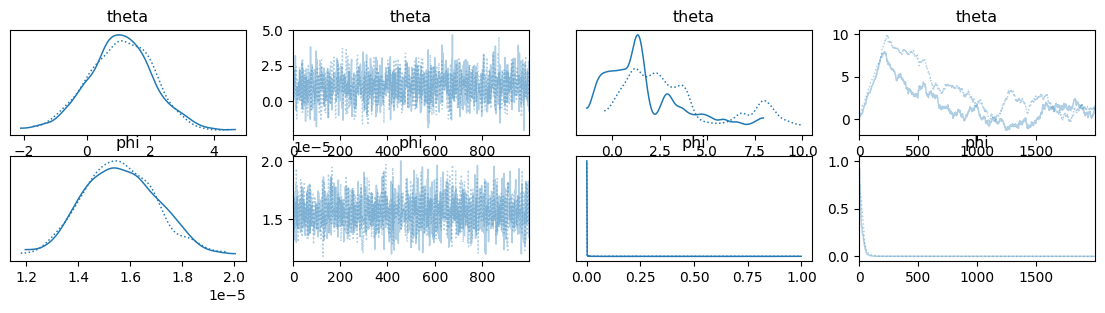

In [5]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,4, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax[:2,:2]); az.plot_trace(idata_MH, axes=ax[:2,2:])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | '); print('MH Split-Rhats',{k: np.round(v.values,4) for k,v in az.rhat(idata_MH).items()})

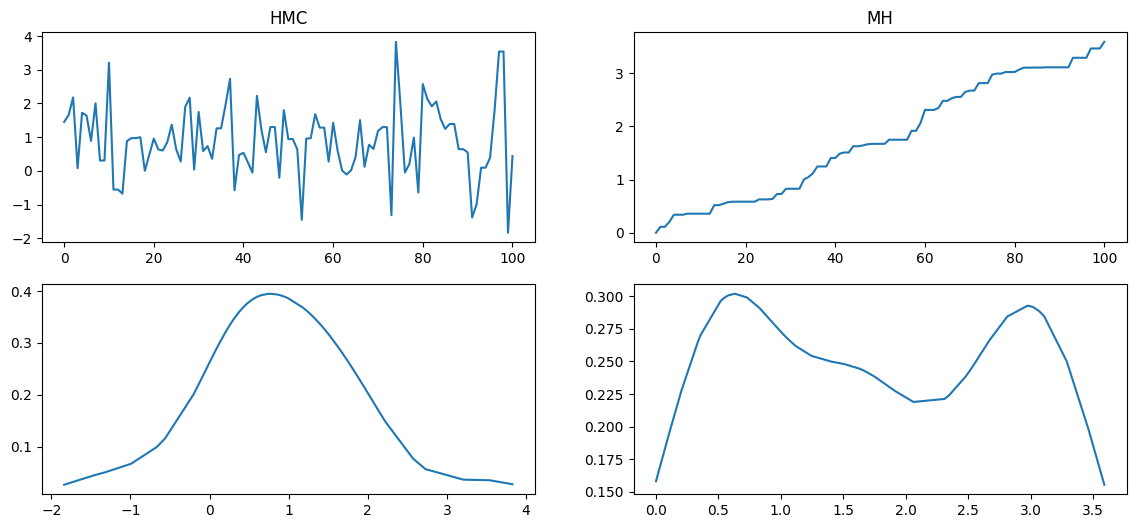

In [6]:
from scipy.stats import gaussian_kde; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,2, figsize=(14,6))
n_mcmc_samples = 100
mcmc_chain = idata_HMC.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,0].plot(mcmc_chain); ax[1,0].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,0].set_title("HMC");
mcmc_chain = idata_MH.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,1].plot(mcmc_chain); ax[1,1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,1].set_title("MH");

Autocorrelation for HMC (MCMC) chain 0.09168986144462923
Autocorrelation for MH (MCMC) chain 0.998310937289593


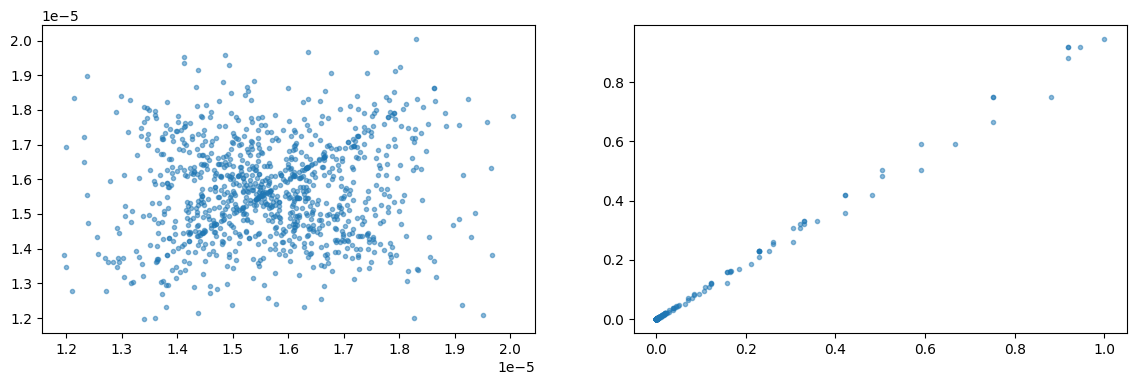

In [7]:
import numpy as np; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,2, figsize=(14,4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["phi"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_HMC.posterior["phi"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])
mcmc_chain = idata_MH.posterior["phi"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_MH.posterior["phi"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for MH (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

In [8]:
import arviz as az
print("number of MCMC samples:", idata_HMC.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2)

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,1.06,1.0,-0.86,2.89,0.03,0.02,1578.75,1274.66,1.0
phi,0.00,0.0,0.00,0.00,0.00,0.00,1619.19,942.45,1.0


In [9]:
print("number of MCMC samples:", idata_MH.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_MH, round_to=2)

number of MCMC samples: 4000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,2.56,2.54,-0.88,8.07,1.33,1.03,3.53,18.08,1.61
phi,0.01,0.08,0.00,0.01,0.01,0.01,13.48,28.59,1.10


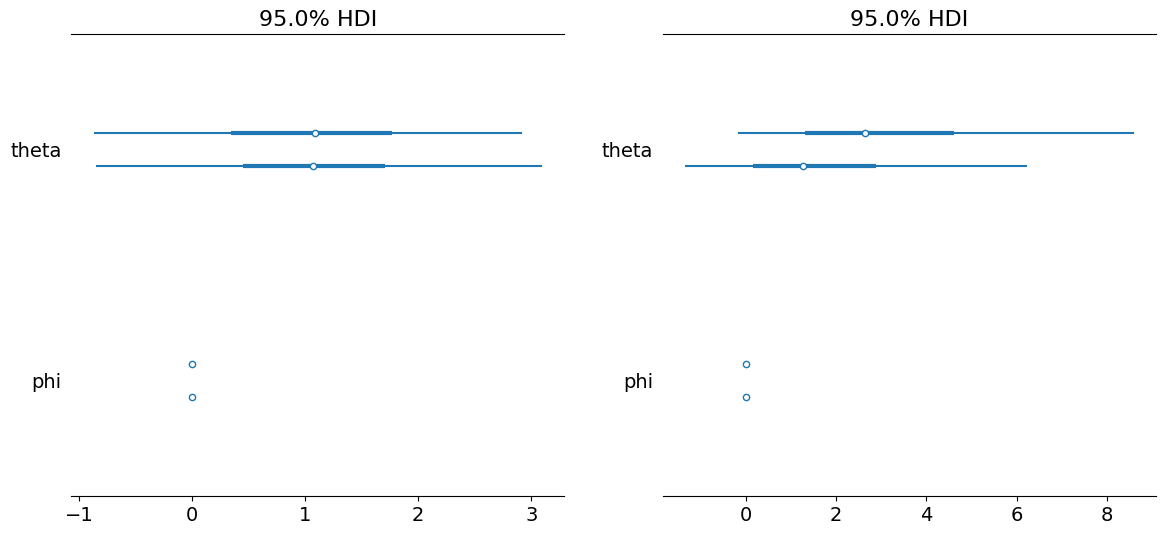

In [10]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["theta","phi"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_MH, var_names=["theta","phi"], combined=False, hdi_prob=0.95, ax=ax[1]);

**2/3/4.**

In [11]:
dataset.rename(columns={'Exercise angina': 'Exercise_angina'}, inplace=True)

In [12]:
import pymc as pm#; from scipy import stats; x = stats.norm().rvs(10)

beta_binomial_toy_model = pm.Model()
with beta_binomial_toy_model:
    theta = pm.Beta("theta", alpha=1, beta=1)
    obs = pm.Binomial("likelihood", n=1, p=theta, observed = dataset['Exercise_angina'])


In [13]:
with beta_binomial_toy_model:
    idata_HMC = pm.sample() # default is the NUTS implementation of HMC

In [14]:
with beta_binomial_toy_model:
    MH = pm.Metropolis([theta], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH = pm.sample(step=MH) # force MH

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:241: RuntimeWarning: invalid value encountered in divide
  self.scaling = tune(self.scaling, self.accepted_sum / float(self.tune_interval))


HMC Split-Rhats {'theta': 1.0021} | MH Split-Rhats {'theta': 1.0084}


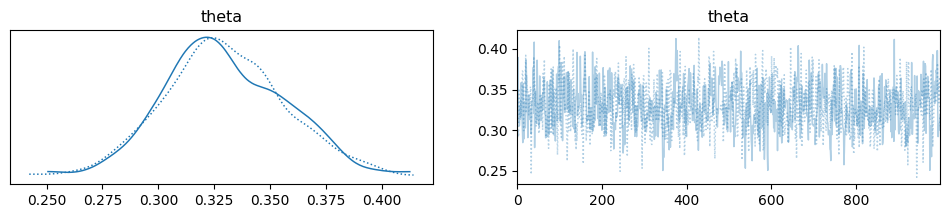

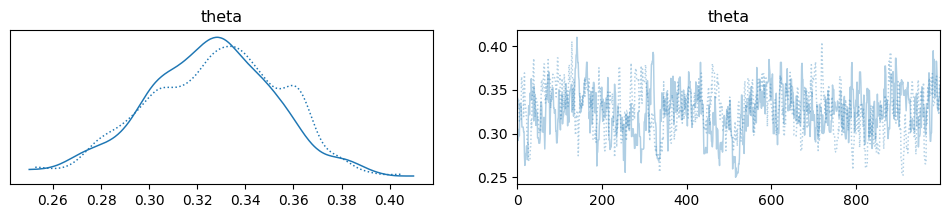

In [15]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_trace(idata_HMC); az.plot_trace(idata_MH)
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | '); print('MH Split-Rhats',{k: np.round(v.values,4) for k,v in az.rhat(idata_MH).items()})

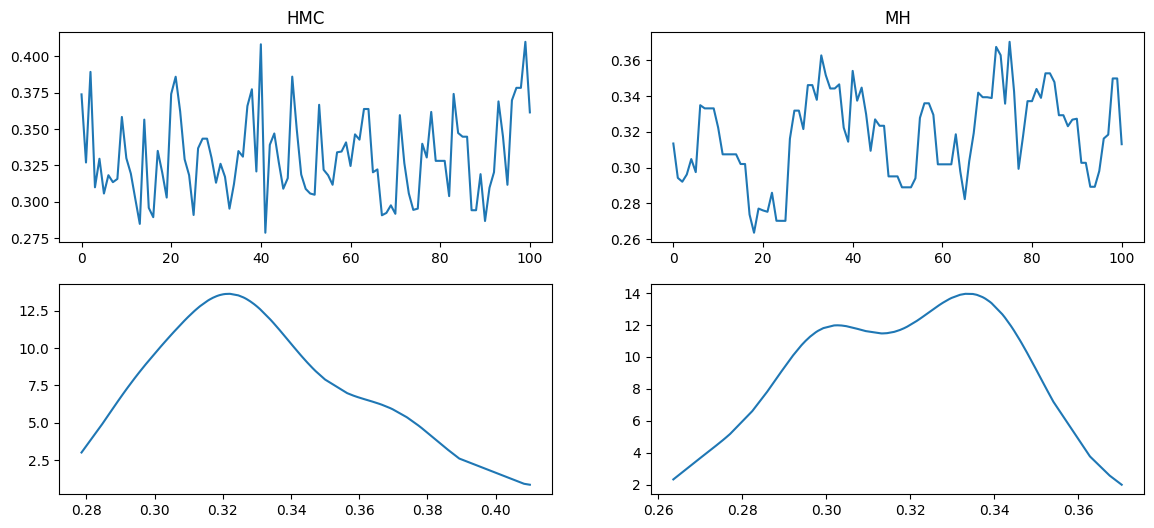

In [16]:
from scipy.stats import gaussian_kde; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,2, figsize=(14,6))
n_mcmc_samples = 100
mcmc_chain = idata_HMC.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,0].plot(mcmc_chain); ax[1,0].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,0].set_title("HMC");
mcmc_chain = idata_MH.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,1].plot(mcmc_chain); ax[1,1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,1].set_title("MH");

Autocorrelation for HMC (MCMC) chain 0.005449784683208293
Autocorrelation for MH (MCMC) chain -0.10887567636160529


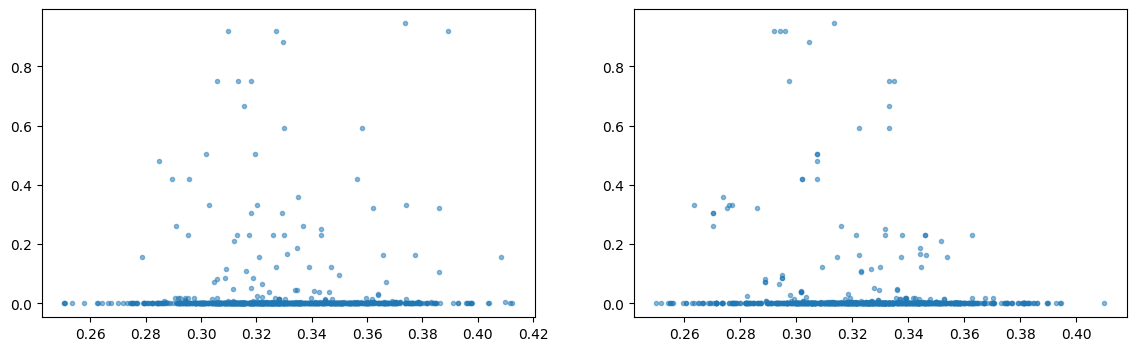

In [17]:
import numpy as np; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,2, figsize=(14,4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["theta"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])
mcmc_chain = idata_MH.posterior["theta"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for MH (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

In [18]:
import arviz as az

print("number of MCMC samples:", idata_HMC.posterior['theta'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2)

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.33,0.03,0.28,0.38,0.0,0.0,852.74,1262.17,1.0


In [19]:
print("number of MCMC samples:", idata_MH.posterior['theta'].values.flatten().shape[-1])
az.summary(idata_MH, round_to=2)

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.33,0.03,0.27,0.37,0.0,0.0,142.65,286.86,1.01


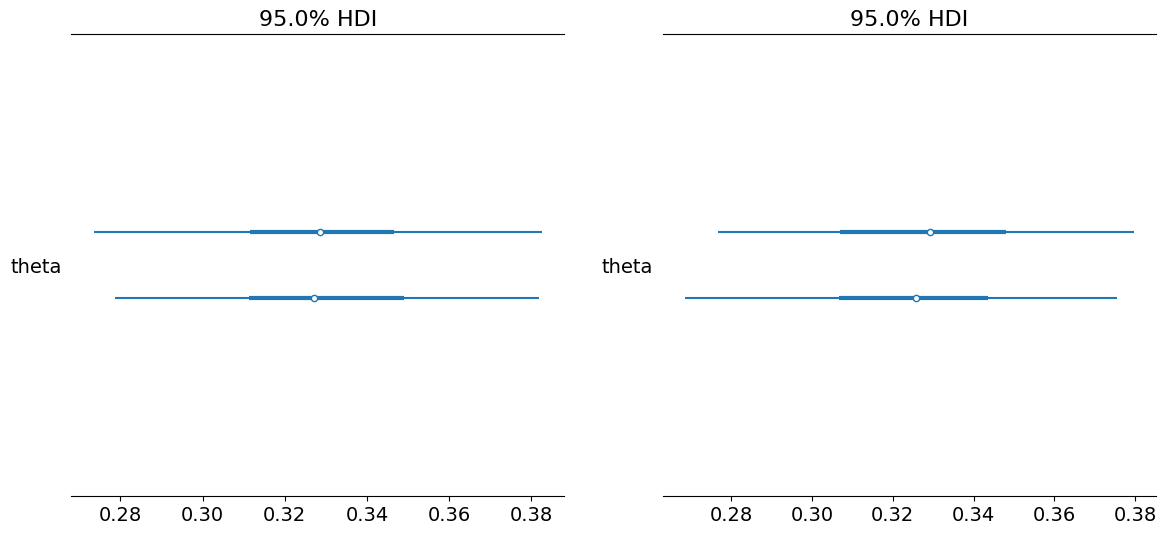

In [20]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_MH, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[1]);